# Numerical Solution of the Two-Dimensional Wave Equation using the Finite Element Method

This notebook illustrates the numerical time-domain solution of the two-dimensional wave equation using the [Finite Element Method](https://en.wikipedia.org/wiki/Finite_element_method) (FEM).

## Problem Statement

The linear and lossless propagation of sound is governed by the inhomogeneous linear [wave equation](https://en.wikipedia.org/wiki/Wave_equation)

\begin{equation}
\Delta p(\mathbf{x}, t) - \frac{1}{c^2} \frac{\partial^2}{\partial t^2} p(\mathbf{x}, t) = - q(\mathbf{x}, t) ,
\end{equation}

where $p(\mathbf{x}, t)$ denotes the sound pressure at position $\mathbf{x}$, $c$ the speed of sound and $q(\mathbf{x}, t)$ the inhomogeneity.
We aim in the following for a numerical solution of the wave equation on the domain $V$ with respect to the homogeneous Dirichlet boundary condition

\begin{equation}
P(\mathbf{x}, \omega) = 0 \qquad \text{for } x \in \partial V , 
\end{equation}

or the homogeneous Neumann boundary condition

\begin{equation}
\frac{\partial}{\partial n} P(\mathbf{x}, \omega) = 0 \qquad \text{for } x \in \partial V ,
\end{equation}

where $\partial V $ denotes the boundary of $V$.

## Variational Formulation

The FEM is based on expressing the partial differential equation (PDE) to be solved in its [variational](https://en.wikipedia.org/wiki/Calculus_of_variations) or weak form.
The first step is to approximate the second-order temporal derivative in the wave equation by its backward [finite difference](https://en.wikipedia.org/wiki/Finite_difference)

\begin{equation}
\frac{\partial^2}{\partial t^2} p(\mathbf{x}, t) \approx \frac{p(\mathbf{x}, t) - 2 p(\mathbf{x}, t - T) + 
p(\mathbf{x}, t- 2 T)}{T^2} ,
\end{equation}

where $T$ denotes the temporal stepsize (sampling interval).
Introducing this approximation into the wave equation and rearranging terms yields

\begin{equation}
c^2 T^2 \Delta p(\mathbf{x}, t) - p(\mathbf{x}, t) = - 2 p(\mathbf{x}, t - T) + 
p(\mathbf{x}, t- 2 T)) - c^2 T^2 q(\mathbf{x}, t) .
\end{equation}

In order to derive the variational formulation we follow the [procedure outlined for the Helmholz equation](FEM_Helmholtz_equation_2D.ipynb#Variational-Formulation).
Multiplication by the test function $v(\mathbf{x}, t)$, integration over the domain $V$ and application of Green's first identity yields

\begin{equation}
- \int_V \left( c^2 T^2  \nabla p(\mathbf{x}, t) \cdot \nabla v(\mathbf{x}, t) +
p(\mathbf{x}, t) v(\mathbf{x}, t) \right) \mathrm{d}x =
\int_V \left( - 2 p(\mathbf{x}, t - T) + 
p(\mathbf{x}, t- 2 T) - c^2 T^2 q(\mathbf{x}, t) \right) v(\mathbf{x}, t) \mathrm{d}x ,
\end{equation}

where  $v(\mathbf{x}, t) = 0$ on $\partial V$ and and a known $p(\mathbf{x}, t)$ (for instance due to fixed boundary condition) was exploited.
It is common to express this in terms of the bilinear $a(P, V)$ and linear $L(V)$ forms 

\begin{equation}
a(P, V) = \int_V \left( c^2 T^2  \nabla p(\mathbf{x}, t) \cdot \nabla v(\mathbf{x}, t) +
p(\mathbf{x}, t) v(\mathbf{x}, t) \right) \mathrm{d}x ,
\end{equation}

\begin{equation}
L(V) = \int_V \left( 2 p(\mathbf{x}, t - T) - p(\mathbf{x}, t- 2 T) + c^2 T^2 q(\mathbf{x}, t) \right) v(\mathbf{x}, t) \mathrm{d}x ,
\end{equation}

where

\begin{equation}
a(P, V) = L(V) .
\end{equation}

## Numerical Solution - Sound Field in Two Coupled Rectangular Rooms

The numerical solution of the variational problem is based on [FEniCS](https://fenicsproject.org/), an open-source framework for numerical solution of PDEs.
Its high-level Python interface `dolfin` is used in the following to define the problem and computing the solution.
The implementation is based on the variational formulation derived above.
The definition of the problem in FEniCS is very close to the mathematical formulation of the problem.
However, it is common in the FEM to denote the solution of the problem by $u$ and the test function by $v$.

For the subsequent example the numerical solution of inhomogeneous two-dimensional wave equation after a total of 300 time steps for a point source $q(\mathbf{x}, t) = \delta(\mathbf{x}-\mathbf{x}_s) \delta(t)$ at position $\mathbf{x}_s = (2,1)$ m is computed for a Dirac shaped exitation in the time-domain.
Note, that the free-field solution of the two-dimensional wave equation for a Dirac shaped excitation is given

\begin{equation}
p(\mathbf{x}, t) = \frac{1}{2 \pi \sqrt{t^2 - (\frac{||\mathbf{x} - \mathbf{x}_s||}{c})^2}} \qquad \text{for } t > \frac{||\mathbf{x} - \mathbf{x}_s||}{c} 
\end{equation}

First, the geometry of the problem is defined and the mesh is plotted with a low number of elements for ease of illustration.

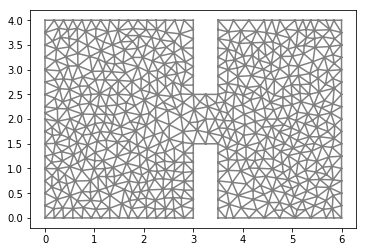

In [1]:
from dolfin import *
import mshr
import matplotlib.pyplot as plt
%matplotlib inline

# define geometry and compute low resolution mesh
domain = mshr.Rectangle(Point(0, 0), Point(3,4)) + mshr.Rectangle(Point(3, 1.5), Point(3.5, 2.5)) + mshr.Rectangle(Point(3.5, 0), Point(6, 4))
mesh = mshr.generate_mesh(domain, 20)
plot(mesh);

Now the problem is defined and solved with FEniCS.

In [2]:
c = 343  # speed of sound
neumann_bc = True  # Neumann or Dirichlet boundary conditions
xs = Point(2, 1)  # source position
T = 1/40000  # temporal sampling interval
N = 300  # total number of timesteps


# high resolution mesh for FEM simulation
mesh = mshr.generate_mesh(domain, 150)

# define function space
V = FunctionSpace(mesh, "CG", 1)

# define previous and second-last solution
u1 = interpolate(Constant(0.0), V)
u0 = interpolate(Constant(0.0), V)

# define boundary conditions
if neumann_bc:
    bcs = None
else:
    bcs = DirichletBC(V, Constant(0.), "on_boundary")

# define variational problem
u = TrialFunction(V)
v = TestFunction(V)

a = inner(u, v) * dx + Constant(T**2 * c**2) * inner(nabla_grad(u), nabla_grad(v)) * dx
L = 2*u1*v * dx - u0*v * dx

# compute solution for all time-steps
u = Function(V)

for n in range(N):
    A, b = assemble_system(a, L, bcs)
    # define inhomogenity
    delta = PointSource(V, xs, float(n==0)) #float(n==0) => float(True if t=0 otherwise False) => 1.0 if t=0 otherwise 0.0
    delta.apply(b)
    # solve variational problem
    solve(A, u.vector(), b)
    u0.assign(u1)
    u1.assign(u)

The resulting sound field is plotted

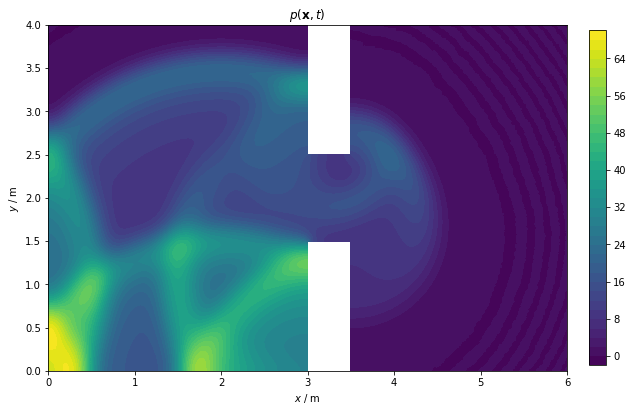

In [3]:
fig = plt.figure(figsize=(10,10))
fig = plot(u)
plt.title(r'$p(\mathbf{x}, t)$')
plt.xlabel(r'$x$ / m')
plt.ylabel(r'$y$ / m')
plt.colorbar(fig, fraction=0.03, pad=0.04);

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).